In [45]:
from pickle import load
from numpy import array
import tensorflow
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
#from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import *
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


In [65]:
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

def create_tokenizer(lines): #assigns id to words in lines vocab
	tokenizer = Tokenizer() #default filters punctuation
	tokenizer.fit_on_texts(lines)
	return tokenizer

def max_length(lines): #max words in a sentence
	return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines): #returns dim (#lines,length)
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	#creates id array from tokenizer ids for each sentence
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post') # adds 0s to the end(post) of sequence
	return X

def encode_output(sequences, vocab_size): #returns 3d
	ylist = np.array([])
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size,dtype=int)
		ylist=np.append(ylist,encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

def load_data(ds_filename, train_ds_fn, test_ds_fn):    
    dataset = load_clean_sentences(ds_filename)
    train = load_clean_sentences(train_ds_fn)
    test = load_clean_sentences(test_ds_fn)
    return dataset,train,test

def prepare_tokenizer(dataset, index):
    tokenizer = create_tokenizer(dataset[:, index])
    vocab_size = len(tokenizer.word_index) + 1
    max_sentence_length = max_length(dataset[:, index])
    return tokenizer,vocab_size,max_sentence_length

def preprocess_input(origin_tok, origin_max_sent_length, target_tok, target_max_sent_length,target_vocab_size, data, one_hot=False):
    dataX = encode_sequences(origin_tok, origin_max_sent_length, data[:, 0])
    dataY = encode_sequences(target_tok, target_max_sent_length, data[:, 1])
    if one_hot:
        dataY = encode_output(dataY, target_vocab_size)
    return dataX,dataY

## GRAPHING LOSS VERSUS EPOCHS
def graph_loss_vs_epochs(history, save_image_filename, title):
    training_loss = history.history['loss']
    test_loss = history.history['val_loss'] #[10 9 8 5 6 7] 3

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1) #[1 2 3 4 5 6]

    # Visualize loss history
    plt.title(title)
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(save_image_filename) 
    plt.axvline(x = epoch_count[test_loss.index(min(test_loss))], color = 'c', linestyle="dotted")
    plt.show()


In [47]:
def train_evaluate_model(trainX, trainY, testX,testY, epochs, batch_size, model, model_save_file_name):
    checkpoint = ModelCheckpoint(model_save_file_name, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,  validation_data=(testX, testY),callbacks=[checkpoint], verbose=2)

def create_model(model,loss_func='categorical_crossentropy',learning_rate=0.001):
    optimizer = Adam(learning_rate)
    model.compile(optimizer=optimizer, loss=loss_func,metrics=['acc'])
    #categorical cross entropy -> one hot encoding output
    #sparse categorical cross entropy -> output as integers
    # summarize defined model
    print(model.summary())
   



In [52]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True)) 
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

def define_model_2(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True)) 
	model.add(GRU(64, return_sequences=True))
	#model.add(RepeatVector(tar_timesteps))
	#model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

2272 4510 5 8
(8000, 5) (8000, 8) (2000, 5) (2000, 8)
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 5, 256)            581632    
_________________________________________________________________
lstm_62 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_31 (RepeatVect (None, 8, 256)            0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 8, 256)            525312    
_________________________________________________________________
time_distributed_31 (TimeDis (None, 8, 4510)           1159070   
Total params: 2,791,326
Trainable params: 2,791,326
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
125/125 - 34s - loss: 3.6275 - acc: 0.63

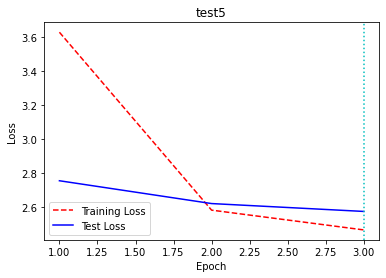

In [67]:
ds_filename, train_ds_fn, test_ds_fn = 'dataset/english-spanish-both-10000.txt', 'dataset/english-spanish-train-10000.txt','dataset/english-spanish-test-10000.txt'
units = 256
learning_rate = 0.001
loss_func='sparse_categorical_crossentropy'
epochs=3
batch_size=64
model_save_file_name='Models/model_test5.h5'

dataset,train,test=load_data(ds_filename, train_ds_fn, test_ds_fn)

eng_tokenizer,eng_vocab_size,eng_max_sentence_length = prepare_tokenizer(dataset,0)
spa_tokenizer,spa_vocab_size,spa_max_sentence_length = prepare_tokenizer(dataset,1)
print(eng_vocab_size,spa_vocab_size,eng_max_sentence_length,spa_max_sentence_length)

trainX, trainY =  preprocess_input(eng_tokenizer, eng_max_sentence_length, spa_tokenizer, spa_max_sentence_length,spa_vocab_size, train, one_hot=False)
testX, testY = preprocess_input(eng_tokenizer, eng_max_sentence_length, spa_tokenizer, spa_max_sentence_length,spa_vocab_size, test, one_hot=False)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

model = define_model(eng_vocab_size, spa_vocab_size, eng_max_sentence_length, spa_max_sentence_length, units)
create_model(model,loss_func,learning_rate)
plot_model(model, to_file='model_images/im5test.png', show_shapes=True)
train_evaluate_model(trainX, trainY, testX,testY, epochs, batch_size, model, model_save_file_name)
graph_loss_vs_epochs(model.history, 'loss_vs_epochs_images/im5test.png', 'test5')